In [1]:
import torch
from torch import nn
from utils import *
import collections
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

##  3.1 Exploring the Dataset

First, download and extract this IMDb review dataset
in the path `./data/aclImdb`.

In [2]:
url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
data_dir = download_extract(url)

We'll start by loading the training data, which includes the reviews and their associated sentiment labels. After loading the data, we'll inspect a few examples to understand the format and content of the reviews and their corresponding sentiment labels. 

An example review might look like: "The movie was fantastic, and I thoroughly enjoyed it." The corresponding label for this positive review would be: 1. 

Conversely, a negative review might look like: "The plot was confusing, and the acting was subpar.". The corresponding label for this negative review would be: 0


In [3]:
train_data = read_imdb(data_dir, is_train=True)
test_data = read_imdb(data_dir, is_train=False)

print('# trainings:', len(train_data[0]))
for x, y in zip(train_data[0][:3], train_data[1][:3]):
    print('label:', y, 'review:', x[:150])

# trainings: 25000
label: 1 review: For a movie that gets no respect there sure are a lot of memorable quotes listed for this gem. Imagine a movie where Joe Piscopo is actually funny! Ma
label: 1 review: Bizarre horror movie filled with famous faces but stolen by Cristina Raines (later of TV's "Flamingo Road") as a pretty but somewhat unstable model wi
label: 1 review: A solid, if unremarkable film. Matthau, as Einstein, was wonderful. My favorite part, and the only thing that would make me go out of my way to see th


Please complete the following function.

When completing this function, consider the following:

- The function should take a text input and split it into individual word tokens (where each word is treated as a separate token).

In the case of word tokenization, a sentence like "The quick brown fox" would be split into individual tokens: ["The", "quick", "brown", "fox"].

In [4]:
def tokenize(lines):
    """Split text lines into word or character tokens."""
    ### START CODE HERE ###
    tokens = []
    for line in lines:
        # Split the line into words and extend the tokens list
        tokens.extend(line.split())
    return tokens
    ### END CODE HERE ###

Please plot the data distribution of the training data using a histogram. The x-axis should represent the length of each review, and the y-axis should indicate the number of corresponding samples. The x-axis will display the lengths of the reviews, while the y-axis will indicate the frequency or count of reviews with similar lengths.

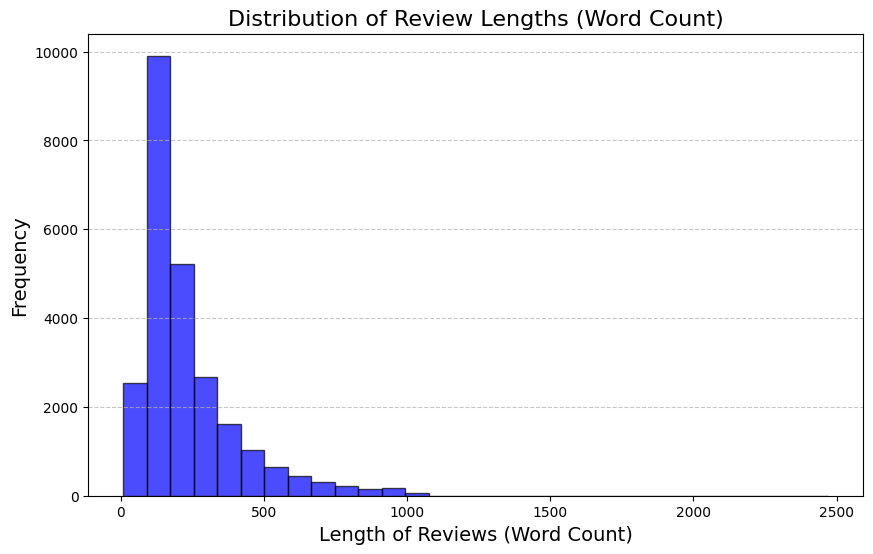

In [5]:
### START CODE HERE ###
review_texts = [review for review in train_data[0]]

review_lengths = [len(tokenize([review])) for review in review_texts]

plt.figure(figsize=(10, 6))
plt.hist(review_lengths, bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Review Lengths (Word Count)', fontsize=16)
plt.xlabel('Length of Reviews (Word Count)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### END CODE HERE ###

The **Vocab** class encapsulates the core operations related to vocabulary management, offering a convenient interface for working with text data in a structured manner.

In [6]:
class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self): 
        return self.token_to_idx['<unk>']


In [7]:
def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))  # Pad

Please complete the **load_data_imdb** function, which aims to facilitate the processing of the IMDb review dataset by providing a data loader and the vocabulary associated with the dataset. To achieve this, the function is expected to utilize predefined functions and classes to handle the dataset and its associated vocabulary. 

**Note: To process a minibatch of such reviews at each time, we set the length of each review to 500 with truncation and padding.**

In [8]:
def load_data_imdb(batch_size, num_steps=500):
    """Return data loader and the vocabulary of the IMDb review dataset."""
    
    train_tokens = [tokenize([review]) for review in train_data[0]]
    test_tokens = [tokenize([review]) for review in test_data[0]]


    vocab = Vocab(train_tokens, min_freq=5)

    train_features = [truncate_pad(vocab[line], num_steps, vocab['<unk>']) for line in train_tokens]
    test_features = [truncate_pad(vocab[line], num_steps, vocab['<unk>']) for line in test_tokens]

    train_labels = torch.tensor([label for label in train_data[1]])
    test_labels = torch.tensor([label for label in test_data[1]])

    train_loader = DataLoader(TensorDataset(torch.tensor(train_features), train_labels),
                              batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(torch.tensor(test_features), test_labels),
                              batch_size=batch_size, shuffle=True)
    
    return train_loader, test_loader, vocab

In [9]:
batch_size = 64
train_iter, test_iter, vocab = load_data_imdb(batch_size)

##  3.2 Using Bidirectional Recurrent Neural Networks for Sentiment Analysis

Please design a multilayer bidirectional RNN to process the IMDB dataset.

In [15]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        ### START CODE HERE ###
        super(BiRNN, self).__init__() 
        self.emb = nn.Embedding(vocab_size, embed_size)

        # Bidirectional LSTM layer
        self.encoder = nn.LSTM(input_size=embed_size,
                               hidden_size=num_hiddens,
                               num_layers=num_layers,
                               bidirectional=True,
                               batch_first=True)

        self.decoder = nn.Linear(4 * num_hiddens, 2)
        ### END CODE HERE ###

    def forward(self, inputs):
        ### START CODE HERE ###
        embeddings = self.emb(inputs)  # input: (batch_size, num_steps)
                                             # output: (batch_size, num_steps, embed_size)

        outputs, _ = self.encoder(embeddings)  # (batch_size, num_steps, 2 * num_hiddens)

        # Concatenate the forward and backward hidden states of the last time step
        encoding = torch.cat((outputs[:, 0, :], outputs[:, -1, :]), dim=1)  # (batch_size, 4 * num_hiddens)

        outs = self.decoder(encoding)  # (batch_size, 2)
        return outs
        ### END CODE HERE ###


In [16]:
embed_size, num_hiddens, num_layers =  100, 128, 2### YOUR CODE HERE ###
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)  ### YOUR CODE HERE ###

Please initialize the weights of your predefined model.

In [17]:
def init_weights(module):
     ### START CODE HERE ###
    if isinstance(module, nn.Linear):
        # use xavier_uniform_ for linear layer
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Embedding):
        # Use uniform initialization for the embedding layer
        nn.init.uniform_(module.weight, -0.1, 0.1)
    elif isinstance(module, nn.LSTM):
        for name, param in module.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)
     ### END CODE HERE ###  
net.apply(init_weights)

BiRNN(
  (emb): Embedding(49346, 100)
  (encoder): LSTM(100, 128, num_layers=2, batch_first=True, bidirectional=True)
  (decoder): Linear(in_features=512, out_features=2, bias=True)
)

Next, we will load the pretrained 100-dimensional GloVe embeddings for tokens in the vocabulary. GloVe (Global Vectors for Word Representation) provides pre-defined dense vectors for a vast number of words in the English language, allowing for immediate utilization in various natural language processing (NLP) applications. The GloVe embeddings are available in different dimensions, such as 50-d, 100-d, 200-d, or 300-d vectors, with the dimensionality indicating the size of the vector representation for each word. To incorporate these pretrained embeddings, it's crucial to ensure consistency with the specified embed_size of 100. By leveraging the GloVe embeddings, we can enrich the model's understanding of the textual data and enhance its performance in NLP tasks.

You can downlaod the **glove.6b.100d** from https://nlp.stanford.edu/data/glove.6B.zip

In [24]:
glove_embedding = TokenEmbedding('glove.6B.100d.txt', '../data/glove.6B')
embeds = glove_embedding[vocab.idx_to_token]

Please use these pretrained word vectors to represent tokens in the reviews and ensure not update these vectors during training.

In [31]:
### START CODE HERE ###
embedding_layer = nn.Embedding.from_pretrained(embeds, freeze=True)
### END CODE HERE ### 

Finally, we will proceed with training our network. Within the following function, you are expected to train your network and evaluate your model on the testing dataset. Additionally, you should generate visualizations depicting the training loss, training accuracy, and testing accuracy for each epoch.

In [34]:
def train(net, train_iter, test_iter, loss, trainer, num_epochs):
    ### START CODE HERE ###
    for epoch in range(num_epochs):
        net.train()
        total_loss, total_correct, total_samples = 0, 0, 0
        
        for inputs, labels in train_iter:
            outputs = net(inputs)
            l = loss(outputs, labels)
            trainer.zero_grad()
            l.backward()
            trainer.step()
            
            total_loss += l.sum().item()
            total_correct += (outputs.argmax(dim=1) == labels).sum().item()
            total_samples += labels.size(0)
        
        train_losses.append(total_loss / total_samples)
        train_accuracies.append(total_correct / total_samples)
        
        net.eval()
        with torch.no_grad():
            correct, total = 0, 0
            for batch in test_iter:
                inputs, labels = batch
                outputs = net(inputs)
                correct += (outputs.argmax(dim=1) == labels).sum().item()
                total += labels.size(0)
            test_accuracy = correct / total
            test_accuracies.append(test_accuracy)
        
        print(f"Epoch {epoch + 1}: Train Loss = {train_losses[-1]:.4f}, "
              f"Train Accuracy = {train_accuracies[-1]:.4f}, "
              f"Test Accuracy = {test_accuracies[-1]:.4f}")

        plt.figure(figsize=(10, 5))
        plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Loss Curve")
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy")
        plt.plot(range(1, num_epochs + 1), test_accuracies, label="Testing Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Accuracy Curve")
        plt.legend()
        plt.show()

    return train_losses, train_accuracies, test_accuracies
    ### END CODE HERE ### 

In [ ]:
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="mean")
train(net, train_iter, test_iter, loss, trainer, num_epochs)

##  3.3 Using TextCNN for Sentiment Analysis

Please design a TextCNN to process the IMDB dataset.

In [ ]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        ### START CODE HERE ###
        self.embedding = nn.Embedding(vocab_size, embed_size)

        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embed_size, 
                      out_channels=num_channels, 
                      kernel_size=k) 
            for k in kernel_sizes
        ])

        self.fc = nn.Linear(num_channels * len(kernel_sizes), 2)

        ### END CODE HERE ### 

    def forward(self, inputs):
        ### START CODE HERE ###
        embeddings = self.embedding(inputs).permute(0, 2, 1)

        conv_outputs = [
            F.relu(conv(embeddings)).max(dim=2)[0]
            for conv in self.convs
        ]

        concat = torch.cat(conv_outputs, dim=1)
        outputs = self.fc(concat)
        ### END CODE HERE ### 

Please initialize the weights of your predefined model.

In [ ]:
def init_weights(module):
    ### START CODE HERE ###
    if isinstance(module, nn.Linear) or isinstance(module, nn.Conv1d):
        nn.init.xavier_uniform_(module.weight)
    elif isinstance(module, nn.Embedding):
        nn.init.normal_(module.weight, mean=0, std=0.01)
    ### END CODE HERE ### 

net.apply(init_weights);

Next, we will load the pretrained 100-dimensional GloVe embeddings for tokens in the vocabulary. 

In [ ]:
glove_embedding = TokenEmbedding('glove.6B.100d.txt', '../data/glove.6B')
embeds = glove_embedding[vocab.idx_to_token]

Please use these pretrained word vectors to represent tokens in the reviews.

In [ ]:
### START CODE HERE ###
embedding_layer = nn.Embedding.from_pretrained(embeds, freeze=True)
### END CODE HERE ### 

Finally, we will proceed with training our network.

In [ ]:
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], 100 ### YOUR CODE HERE ###
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels) ### YOUR CODE HERE ###

In [ ]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="mean")
train(net, train_iter, test_iter, loss, trainer, num_epochs)

Make the prediction for a text sequence.

In [ ]:
def predict_sentiment(net, vocab, sequence):
    """Predict the sentiment of a text sequence."""
    tokens = sequence.lower().split()
    indices = [vocab[token] for token in tokens if token in vocab]

    inputs = torch.tensor(indices).unsqueeze(0)  # (1, seq_len)

    net.eval()
    with torch.no_grad():
        outputs = net(inputs)
        predicted_class = torch.argmax(outputs, dim=1).item()

    sentiment = "positive" if predicted_class == 1 else "negative"
    print(sentiment)
    return sentiment
    ### START CODE HERE ###
    ### END CODE HERE ### 

In [ ]:
predict_sentiment(net, vocab, 'this movie is so great')

In [ ]:
predict_sentiment(net, vocab, 'this movie is so bad')